In [1]:
%env OMP_NUM_THREADS=10
%pylab inline
%load_ext autoreload
%autoreload 2

env: OMP_NUM_THREADS=10
Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
import sys
import cv2
import math
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import inspect
from collections import namedtuple
import time
import glob
from imageio import imread, imsave
print('USE GPU #{} Host={}'.format(os.environ.get('CUDA_VISIBLE_DEVICES'), os.uname()[1]))

USE GPU #0 Host=multi-agent


In [3]:
LOCAL_PATH = '../'
if LOCAL_PATH not in sys.path:
    sys.path.append(LOCAL_PATH)
from common.tf_layer_utils import *
from datasets import *
from det_tools import *
MODEL_PATH = '../models/'
if MODEL_PATH not in sys.path:
    sys.path.append(MODEL_PATH)
COMMON_PATH = '../common/'
if COMMON_PATH not in sys.path:
    sys.path.append(COMMON_PATH)
    
from io_utils import read_text
from jupyter_utils import display_image_batch # make sure you finish preparation described at jupyter_utils.py

## Dataset Loading and Image warping

### Outdoor scenes (YFCC)

In [4]:
yfcc_dir = '../release/outdoor_examples/'
img_dir = os.path.join(yfcc_dir, 'images')
dpt_dir = os.path.join(yfcc_dir, 'depths')
seq_names = ['sacre_coeur']
batch_size = 8
data_raw_size = 362 # data_size * sqrt(2)
data_size = 256
aug_max_degree = 180
aug_max_scale = 1.0
depth_thresh = 10.0 # depend on dataset

In [5]:
tf.reset_default_graph()
data_loader = SfMDataset(out_size=(data_raw_size, data_raw_size),
                         warp_aug_mode='random', flip_pair=True,
                         max_degree=aug_max_degree, max_scale=aug_max_scale,
                        )
dataset = data_loader.get_dataset(dpt_dir, img_dir, seq_names, phase='train',
                                  batch_size=batch_size, shuffle=True, seed=1234)
next_batch = dataset.make_one_shot_iterator().get_next()
next_batch = euclidean_augmentation(next_batch, (data_size, data_size), rot_aug=True, scale_aug=False)

sacre_coeur has 75073 examples
aug_mode=random max_rad=3.141592653589793, max_scale_log=0.0
Add random logscale=-0.00~0.00, ori=-3.141592653589793~3.141592653589793
Tensor("strided_slice_1:0", shape=(?, ?), dtype=float32)
(256, 256)
(256, 256)


In [6]:
photos1, photos2, depths1, depths2, valid_masks1, valid_masks2, c2Tc1s, c1Tc2s, c1Tws, c2Tws, Ks1, Ks2, thetas1, thetas2, inv_thetas1, inv_thetas2, theta_params = next_batch
batch, height, width, _ = tf.unstack(tf.shape(photos1))

photos1w, visible_masks1, xy_maps1to2 = \
    inverse_warp_view_2_to_1(photos2, depths2, depths1, c2Tc1s, 
                            K1=Ks1, K2=Ks2, 
                            inv_thetas1=inv_thetas1, thetas2=thetas2,
                            depth_thresh=depth_thresh)
photos2w, visible_masks2, xy_maps2to1 = \
    inverse_warp_view_2_to_1(photos1, depths1, depths2, c1Tc2s, 
                            K1=Ks2, K2=Ks1,
                            inv_thetas1=inv_thetas2, thetas2=thetas1,
                            depth_thresh=depth_thresh)
visible_masks1 = visible_masks1 * valid_masks1 # take 'and'
visible_masks2 = visible_masks2 * valid_masks2

diff1 = tf.abs(visible_masks1*(photos1-photos1w))
diff2 = tf.abs(visible_masks2*(photos2-photos2w))

canvas1 = tf.concat([photos1, photos1w, diff1], axis=2)
canvas2 = tf.concat([photos2, photos2w, diff2], axis=2)
canvas = tf.concat([canvas1, canvas2], axis=1)

In [7]:
tfconfig = tf.ConfigProto()
tfconfig.gpu_options.allow_growth = True 
sess = tf.Session(config=tfconfig)
sess.run(tf.global_variables_initializer())

In [8]:
fetch_dict = {
    'canvas': canvas,
}

outs = sess.run(fetch_dict)

In [9]:
display_image_batch(outs['canvas'])

../common/jupyter_utils.py:18: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if isinstance(batch, np.ndarray) and np.issubdtype(batch.dtype, np.float):


interactive(children=(IntSlider(value=3, description='idx', max=7), Output()), _dom_classes=('widget-interact'…

## View keypoints from dumped npz
You need to run run_lfnet.py first

In [10]:
img_name = '00204549_3820006713.jpg'
img_path = '/home/zoe/deeplearning/lfnet/dump_feats/'+img_name
kp_path = '/home/zoe/deeplearning/lfnet/dump_feats/{}.npz'.format(img_name)
image = imread(img_path).astype(np.float32) / 255
kp_info = np.load(kp_path)
kpts = kp_info['kpts']
feats = kp_info['descs']
height, width = kp_info['size']
image = cv2.resize(image, (width, height))
print('Load {}-kpts, feat={}-D imsize={}x{}'.format(kpts.shape[0], feats.shape[1], width, height))

Load 500-kpts, feat=256-D imsize=640x420


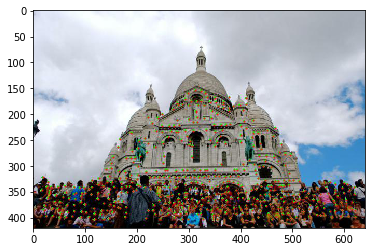

In [11]:
plt.imshow(image)
plt.plot(
    kpts[:,0], kpts[:,1],
    alpha=1,
    linestyle='none',
    linewidth=0,
    aa=False,
    marker='.',
    markersize=2,
    color=[0.9, 0.1, 0.1],
);

### Indoor scenes (ScanNet)

In [12]:
scannet_dir = '/cvlabdata1/home/ono/datasets/scannet/dataset/all/valid' # set your own path
render_text = '/cvlabdata1/home/ono/datasets/scannet/dataset/valid_nips.txt'
render_paths = [x for x in read_text(render_text)]

batch_size = 8
pair_offset = 30
random_offset = False
data_raw_size = 362 # data_size * sqrt(2)
data_size = 256
aug_max_degree = 180
aug_max_scale = 1.0
depth_thresh = 1.0 # depend on dataset

FileNotFoundError: [Errno 2] No such file or directory: '/cvlabdata1/home/ono/datasets/scannet/dataset/valid_nips.txt'

In [ ]:
tf.reset_default_graph()

data_loader = SE3PairwiseDataset(batch_size, offset_val=pair_offset, random_offset=random_offset,
                out_width=data_raw_size, out_height=data_raw_size, 
                crop_center=True,
                max_degree=aug_max_degree, max_scale=aug_max_scale, warp_aug_mode='random')
data_loader.set_files(scannet_dir, render_paths, max_img_num=500)

In [ ]:
dataset = data_loader.get_dataset(shuffle=True)
next_batch = dataset.make_one_shot_iterator().get_next()
next_batch = euclidean_augmentation(next_batch, (data_size, data_size), rot_aug=True, scale_aug=True)

In [ ]:
photos1, photos2, depths1, depths2, valid_masks1, valid_masks2, c2Tc1s, c1Tc2s, c1Tws, c2Tws, Ks1, Ks2, thetas1, thetas2, inv_thetas1, inv_thetas2, theta_params = next_batch
batch, height, width, _ = tf.unstack(tf.shape(photos1))

photos1w, visible_masks1, xy_maps1to2 = \
    inverse_warp_view_2_to_1(photos2, depths2, depths1, c2Tc1s, 
                            K1=Ks1, K2=Ks2, 
                            inv_thetas1=inv_thetas1, thetas2=thetas2,
                            depth_thresh=depth_thresh)
photos2w, visible_masks2, xy_maps2to1 = \
    inverse_warp_view_2_to_1(photos1, depths1, depths2, c1Tc2s, 
                            K1=Ks2, K2=Ks1,
                            inv_thetas1=inv_thetas2, thetas2=thetas1,
                            depth_thresh=depth_thresh)
visible_masks1 = visible_masks1 * valid_masks1 # take 'and'
visible_masks2 = visible_masks2 * valid_masks2

diff1 = tf.abs(visible_masks1*(photos1-photos1w))
diff2 = tf.abs(visible_masks2*(photos2-photos2w))

canvas1 = tf.concat([photos1, photos1w, diff1], axis=2)
canvas2 = tf.concat([photos2, photos2w, diff2], axis=2)
canvas = tf.concat([canvas1, canvas2], axis=1)

In [ ]:
tfconfig = tf.ConfigProto()
tfconfig.gpu_options.allow_growth = True 
sess = tf.Session(config=tfconfig)
sess.run(tf.global_variables_initializer())

In [ ]:
fetch_dict = {
    'canvas': canvas,
}

outs = sess.run(fetch_dict)

In [ ]:
outs['canvas'].shape

In [ ]:
plt.imshow(outs['canvas'][0,...,0])